# **SEATTLE CRIME ON THE DIME**
Adamou Tidjani, Gina Philipose, and Trinh Tran

*The project is about forecasting the location and number of crimes that occur in the neighborhoods of Seattle. We are using data from the Seattle Police Department (SPD) which contains 1.49 million rows and 19 columns. We have identified 13 columns of interest that will help us achieve our goal. Our objective is to create a model that we can hand off to the city to help them predict where a crime would have more likely occurred given the time and type of crime. For example, let’s say someone is a victim of a crime at a certain time and might not know where they are located, the police officers can use our model to best predict where they should intervene and possibly save that person’s life.*

### Importing libraries

In [ ]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, widgets
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn import tree

### Reading the data

In [ ]:
url = "https://huggingface.co/datasets/tnltrinh/seattle_crime/resolve/main/dataset/origional_ds.csv"
crime_data = pd.read_csv(
    url,
    na_values=['-', 'REDACTED','UNKNOWN', 'FK ERROR'],
    low_memory=False
)

In [ ]:


https://huggingface.co/datasets/tnltrinh/seattle_crime/resolve/main/dataset/origional_ds.csv

## Transform & pre-processing data

In [ ]:
crime_data["Report DateTime"] = pd.to_datetime(
    crime_data["Report DateTime"], errors='coerce'
)
crime_data["Offense Date"] = pd.to_datetime(
    crime_data["Offense Date"], errors='coerce'
)

/tmp/ipython-input-1583285012.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data["Report DateTime"] = pd.to_datetime(
/tmp/ipython-input-1583285012.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data["Offense Date"] = pd.to_datetime(


Extract day, month, year to group by and visualize data easier

In [ ]:
crime_data["Report_Year"] = crime_data["Report DateTime"].dt.year
crime_data["Report_Month"] = crime_data["Report DateTime"].dt.month
crime_data["Report_Day"] = crime_data["Report DateTime"].dt.day

crime_data["Offense_Year"] = crime_data["Offense Date"].dt.year
crime_data["Offense_Month"] = crime_data["Offense Date"].dt.month
crime_data["Offense_Day"] = crime_data["Offense Date"].dt.day

Transform other columns datatype to correct datatypes:

In [ ]:
# Convert numeric object columns to int or float
crime_data['Offense ID'] = pd.to_numeric(crime_data['Offense ID'], errors='coerce').astype('Int64')

# Convert columns to string
string_columns = [
    'Report Number',
    'NIBRS Group AB',
    'NIBRS Crime Against Category',
    'Offense Sub Category',
    'Shooting Type Group',
    'Block Address',
    'Beat',
    'Precinct',
    'Sector',
    'Neighborhood',
    'Reporting Area',
    'Offense Category',
    'NIBRS Offense Code Description',
    'NIBRS_offense_code'
]

crime_data[string_columns] = crime_data[string_columns].astype('string')

# Convert coordinates to float
crime_data['Latitude'] = pd.to_numeric(crime_data['Latitude'], errors='coerce').astype('float')
crime_data['Longitude'] = pd.to_numeric(crime_data['Longitude'], errors='coerce').astype('float')

Create an additional **duration** column which means the duration from the Report DateTime and Offense Date

In [ ]:
crime_data['Duration'] = crime_data['Report DateTime'] - crime_data['Offense Date']

# Move 'duration' right after 'Offense Date'
cols = list(crime_data.columns)
offense_index = cols.index('Offense Date')
cols.insert(offense_index + 1, cols.pop(cols.index('Duration')))
crime_data = crime_data[cols]

Scaling the chart to repsent data from 2008 to 2024

In [ ]:
crime_data = crime_data[(crime_data['Offense_Year'] >= 2008) & (crime_data['Offense_Year'] <= 2024)]

In [ ]:
crime_data['Report_Hour'] = crime_data['Report DateTime'].dt.hour
crime_data['Offense_Hour'] = crime_data['Offense Date'].dt.hour
crime_data['Report_DayOfWeek'] = crime_data['Report DateTime'].dt.day_name()
crime_data['Offense_DayOfWeek'] = crime_data['Offense Date'].dt.day_name()

## Implementing and Training models

## Decision Tree (Predicting Neighborhood)

*   ### Data Preparation


In [ ]:
df_filtered = crime_data.dropna(subset=['Neighborhood'])

# Target variable
y = df_filtered['Neighborhood']

# Features
feature_list = [
    'Offense Sub Category',
    'Offense_Hour',
    'Offense_DayOfWeek'
]


X = df_filtered[feature_list].copy()

# Filling any missing categorical features with "Unknown"
X['Offense Sub Category'] = X['Offense Sub Category'].fillna('Unknown')
X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].fillna('Unknown')

X_processed = pd.get_dummies(X)

*   ### Splitting the data into train/test and feature selection

In [ ]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Building  model
draft_model = DecisionTreeClassifier(random_state=42)
draft_model.fit(X_train, y_train)

# Getting the feature importances
importances = draft_model.feature_importances_
feature_names = X_processed.columns

# Seeing the most important features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})


# Sorting and printing the top 20 features
print("Feature importances for predicting 'Precinct':")
print(feature_importance_df.sort_values(by='Importance', ascending=False).head(20))

Feature importances for predicting 'Precinct':
                                              Feature  Importance
0                                        Offense_Hour    0.202505
20   Offense Sub Category_NON-VIOLENT FAMILY OFFENSES    0.155151
30  Offense Sub Category_VIOLATION OF NO CONTACT O...    0.103341
16                 Offense Sub Category_LARCENY-THEFT    0.066130
23         Offense Sub Category_PROSTITUTION OFFENSES    0.057279
1                            Offense Sub Category_999    0.048281
28                      Offense Sub Category_TRESPASS    0.040407
17  Offense Sub Category_LIQUOR LAW VIOLATIONS & D...    0.039684
19  Offense Sub Category_NARCOTIC VIOLATIONS (INCL...    0.033727
6               Offense Sub Category_ASSAULT OFFENSES    0.022867
3                      Offense Sub Category_ALL OTHER    0.020384
7                       Offense Sub Category_BURGLARY    0.020047
34                         Offense_DayOfWeek_Saturday    0.019647
35                           

* ### Building the model and printing accuracy

In [ ]:
# Building the final
final_model = DecisionTreeClassifier(max_depth=7, random_state=42)
final_model.fit(X_train, y_train)

# Checking its accuracy
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")

Final Model Accuracy: 19.89%


* ### Displaying Decision Tree

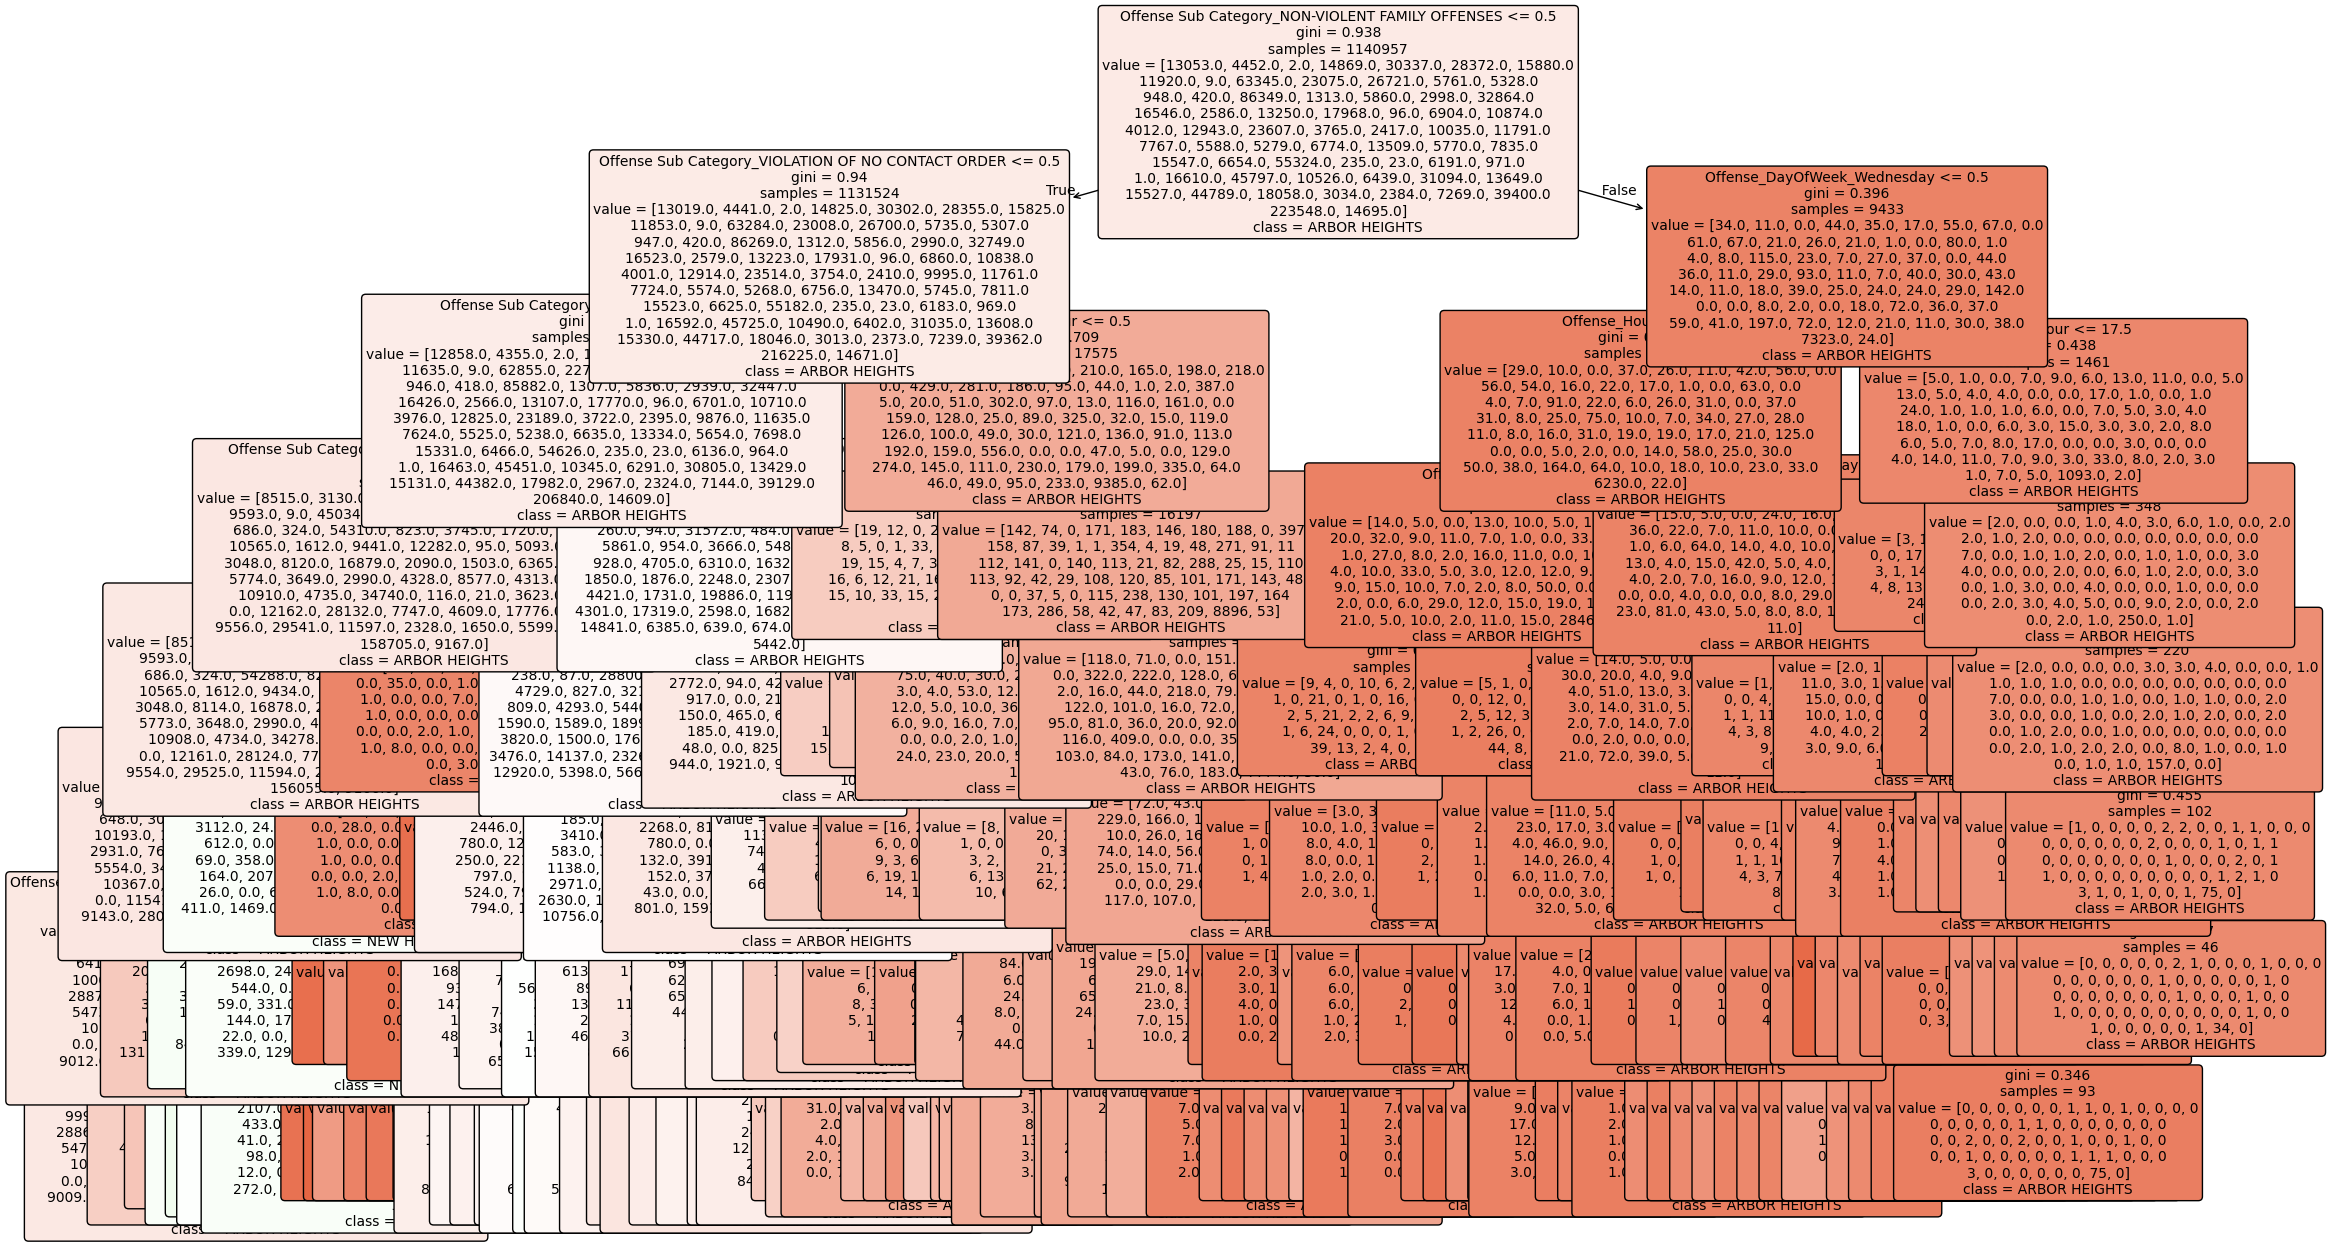

In [ ]:
plt.figure(figsize=(25, 15))
plot_tree(final_model,
          feature_names=feature_names,
          class_names=y_train.unique(),
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

## Decision Tree (Predicting Precinct)


*   ### Data Preparation

In [ ]:
df_filtered = crime_data.dropna(subset=['Precinct'])

# Target variable
y = df_filtered['Precinct']

# Features
feature_list = [
    'Offense Sub Category',
    'Offense_Hour',
    'Offense_DayOfWeek'
]


X = df_filtered[feature_list].copy()

# Filling any missing categorical features with "Unknown"
X['Offense Sub Category'] = X['Offense Sub Category'].fillna('Unknown')
X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].fillna('Unknown')

X_processed = pd.get_dummies(X)

*   ### Splitting the data into train/test and feature selection

In [ ]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Building  model
draft_model = DecisionTreeClassifier(random_state=42)
draft_model.fit(X_train, y_train)

# Getting the feature importances
importances = draft_model.feature_importances_
feature_names = X_processed.columns

# Seeing the most important features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})


# Sorting and printing the top 20 features
print("Feature importances for predicting 'Precinct':")
print(feature_importance_df.sort_values(by='Importance', ascending=False).head(20))

Feature importances for predicting 'Precinct':
                                              Feature  Importance
0                                        Offense_Hour    0.256011
19  Offense Sub Category_NARCOTIC VIOLATIONS (INCL...    0.111658
18           Offense Sub Category_MOTOR VEHICLE THEFT    0.095415
16                 Offense Sub Category_LARCENY-THEFT    0.071659
7                       Offense Sub Category_BURGLARY    0.060280
10  Offense Sub Category_EXTORTION/FRAUD/FORGERY/B...    0.047292
23         Offense Sub Category_PROSTITUTION OFFENSES    0.031627
34                         Offense_DayOfWeek_Saturday    0.029693
35                           Offense_DayOfWeek_Sunday    0.028491
22  Offense Sub Category_PROPERTY OFFENSES (INCLUD...    0.027317
32                           Offense_DayOfWeek_Friday    0.024005
37                          Offense_DayOfWeek_Tuesday    0.019574
30  Offense Sub Category_VIOLATION OF NO CONTACT O...    0.019350
38                        Off

* ### Building the model and printing accuracy

In [ ]:
# Building the final
final_model = DecisionTreeClassifier(max_depth=7, random_state=42)
final_model.fit(X_train, y_train)

# Checking its accuracy
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")

Final Model Accuracy: 32.72%


* ### Displaying Decision Tree

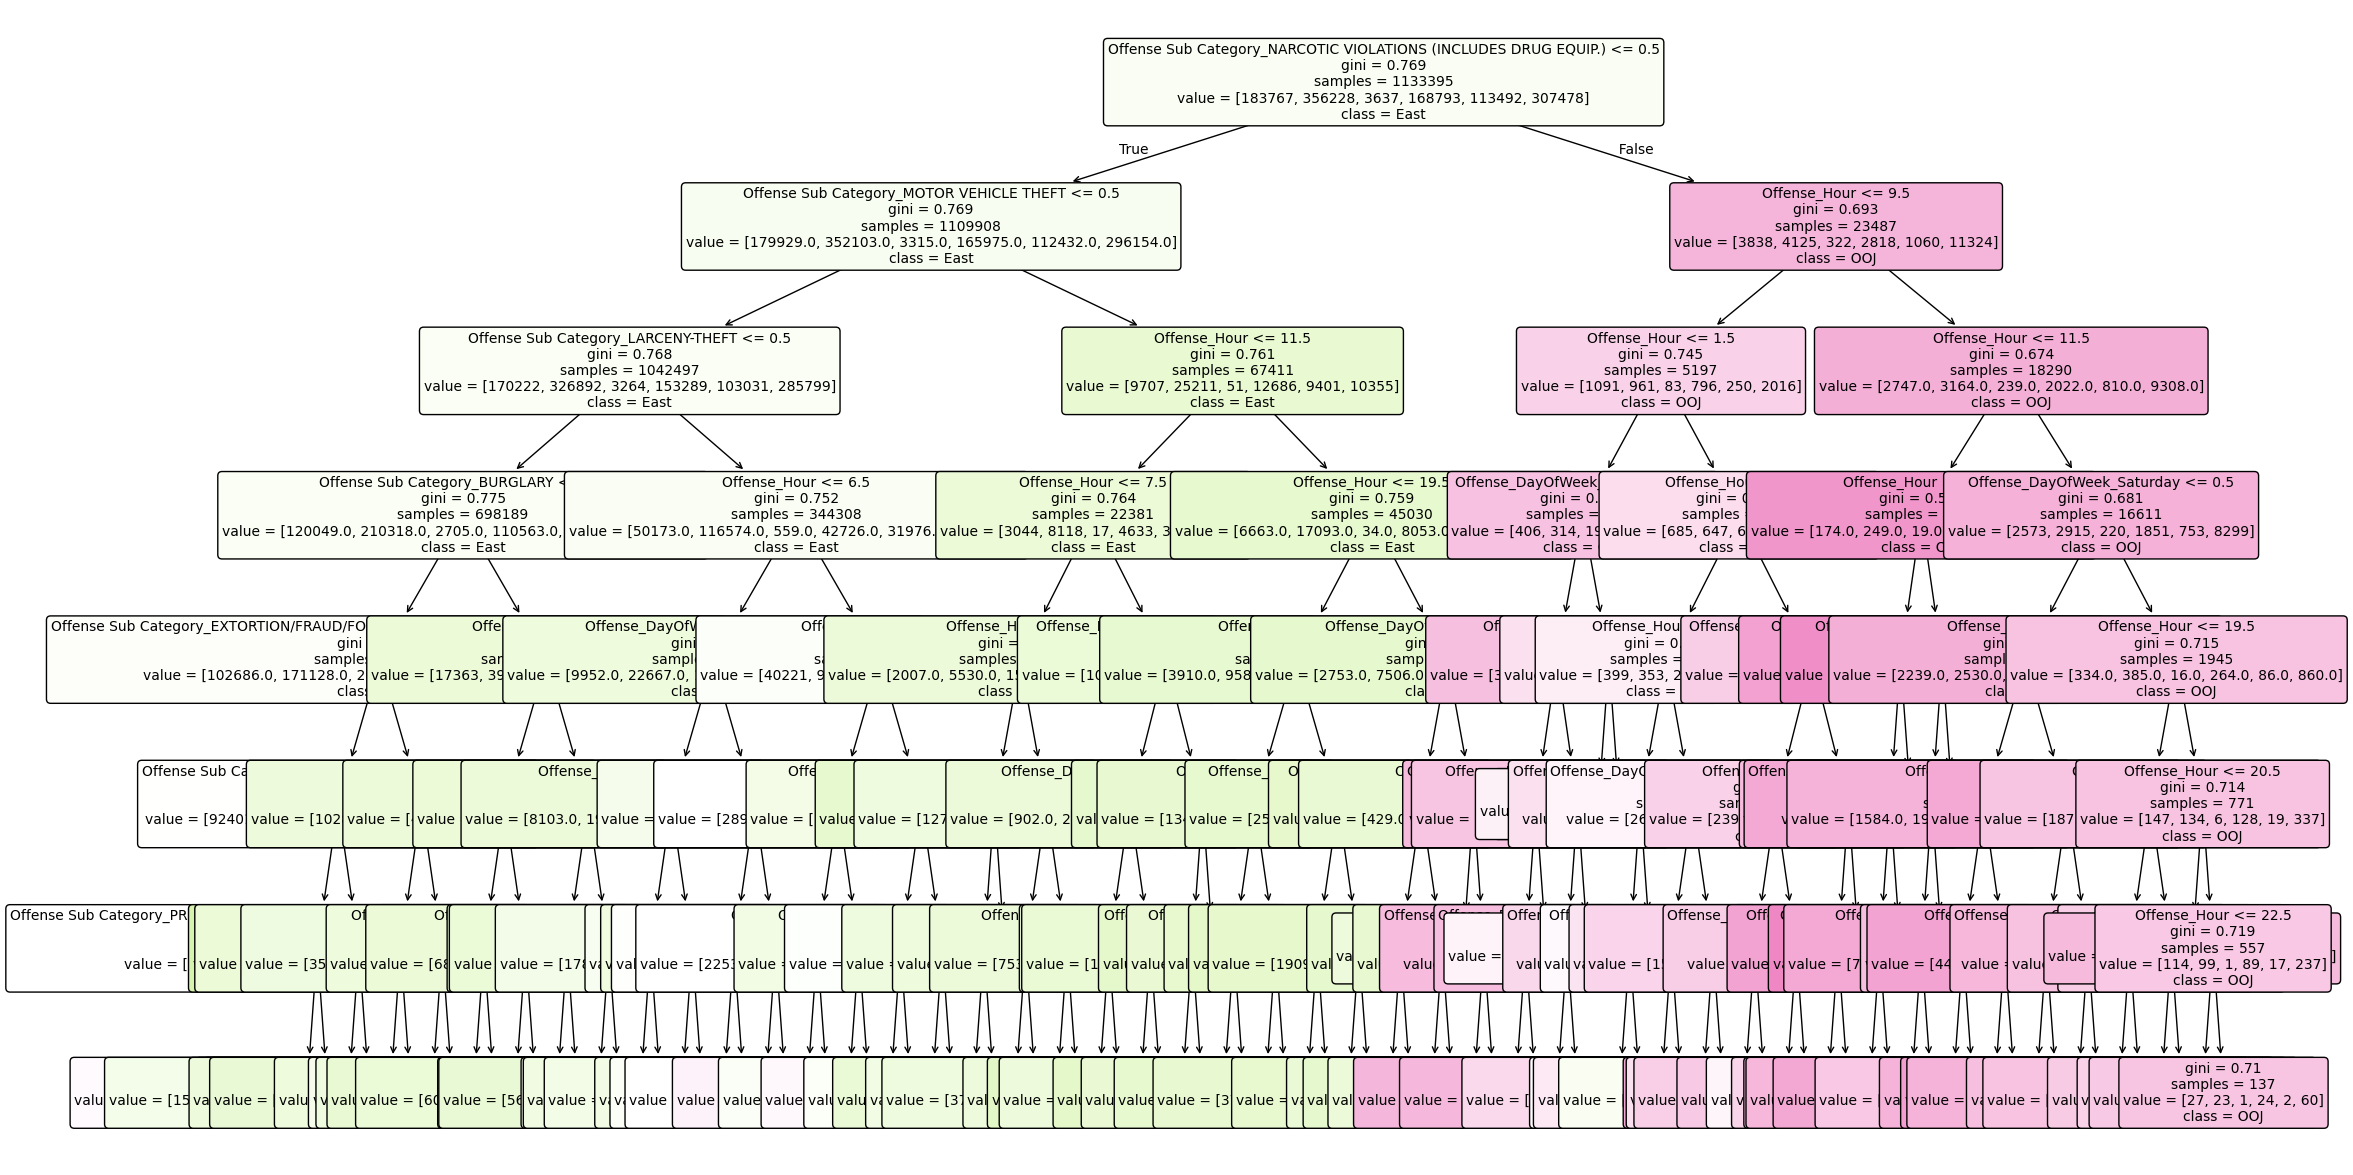

In [ ]:
plt.figure(figsize=(25, 15))
plot_tree(final_model,
          feature_names=feature_names,
          class_names=y_train.unique(),
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

### Checking Class Imbalance

In [ ]:
print(f"Total unique neighborhoods: {y.nunique()}")

# percentage of the top 10
print("\nTop 10 Neighborhoods by %:")
print(y.value_counts(normalize=True).head(10) * 100)

Total unique neighborhoods: 6

Top 10 Neighborhoods by %:
Precinct
North         31.40878
West         27.125084
East         16.225797
South        14.884623
Southwest    10.033923
OOJ           0.321794
Name: proportion, dtype: Float64


### Fixing class imbalance problem



In [ ]:

df_filtered = crime_data.dropna(subset=['Precinct'])

# Target variable
y = df_filtered['Precinct']

# Features
feature_list = [
    'Offense Sub Category',
    'Offense_Hour',
]

X = df_filtered[feature_list].copy()

# Filling any missing categorical features with "Unknown"
X['Offense Sub Category'] = X['Offense Sub Category'].fillna('Unknown')

X_processed = pd.get_dummies(X, dtype=int)

# Splitting the data into Train and Test (BEFORE resampling)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Applying SMOTE only to the training data
print(f"Original training shape: {X_train.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training shape: {X_train_resampled.shape}")

# Training the model on the NEW resampled data
final_model = DecisionTreeClassifier(max_depth=7, random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)

# Evaluating on the ORIGINAL test set
y_pred = final_model.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

Original training shape: (1133395, 32)
Resampled training shape: (2137368, 32)

--- Classification Report ---
              precision    recall  f1-score   support

        East       0.22      0.01      0.02     46111
       North       0.37      0.11      0.17     88754
         OOJ       0.01      0.56      0.02       922
       South       0.20      0.04      0.06     42084
   Southwest       0.15      0.05      0.07     28663
        West       0.28      0.69      0.40     76815

    accuracy                           0.23    283349
   macro avg       0.20      0.24      0.12    283349
weighted avg       0.27      0.23      0.18    283349



## RandomForest (Predicting Precinct)

In [ ]:
# Building the model
final_model = RandomForestClassifier(random_state=42)

# Training on the resampled data
final_model.fit(X_train_resampled, y_train_resampled)

print("Training complete!")

# Evaluating on the ORIGINAL test set
y_pred = final_model.predict(X_test)

# Printing the report
print("\n--------------------- Random Forest Classification Report ---------------------------")
print(classification_report(y_test, y_pred))

df_filtered = crime_data.dropna(subset=['Precinct'])

# target variable
y = df_filtered['Precinct']

# feature list
feature_list = [
    'Offense Sub Category', # Categorical
    'Offense_Hour',     # Numeric
]

X = df_filtered[feature_list].copy()

Training complete!

--------------------- Random Forest Classification Report ---------------------------
              precision    recall  f1-score   support

        East       0.21      0.09      0.13     46111
       North       0.37      0.21      0.27     88754
         OOJ       0.01      0.62      0.02       922
       South       0.20      0.16      0.18     42084
   Southwest       0.13      0.22      0.16     28663
        West       0.33      0.28      0.30     76815

    accuracy                           0.21    283349
   macro avg       0.21      0.27      0.18    283349
weighted avg       0.28      0.21      0.23    283349



Index(['Report Number', 'Report DateTime', 'Offense Date', 'Duration',
       'NIBRS Group AB', 'NIBRS Crime Against Category',
       'Offense Sub Category', 'Shooting Type Group', 'Block Address',
       'Latitude', 'Longitude', 'Beat', 'Precinct', 'Sector', 'Neighborhood',
       'Reporting Area', 'Offense Category', 'NIBRS Offense Code Description',
       'NIBRS_offense_code', 'Report_Year', 'Report_Month', 'Report_Day',
       'Offense_Year', 'Offense_Month', 'Offense_Day', 'Report_Hour',
       'Offense_Hour', 'Report_DayOfWeek', 'Offense_DayOfWeek'],
      dtype='object')

In [ ]:


# Filling Missing Values (Safety Check)
# Filling any missing categorical features with "Unknown"
X['Offense Sub Category'] = X['Offense Sub Category'].fillna('Unknown')

# Creating Dummy Variables (using dtype=int to prevent errors)
# This will automatically find and convert all string columns
X_processed = pd.get_dummies(X, dtype=int)

print(f"Original data shape: {X_processed.shape}")

# Splitting the data BEFORE resampling
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Applying SMOTE only to the training data
print(f"Original training shape: {X_train.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training shape: {X_train_resampled.shape}")

# Training the Random Forest on the resampled data
print("Training a Random Forest model... (This may take a few minutes)")
final_model = RandomForestClassifier(random_state=42, n_jobs=-1)
final_model.fit(X_train_resampled, y_train_resampled)
print("Training complete!")

Original data shape: (1416744, 32)
Original training shape: (1133395, 32)
Resampled training shape: (2137368, 32)
Training a Random Forest model... (This may take a few minutes)
Training complete!


In [ ]:
# Evaluating on the ORIGINAL test set
y_pred = final_model.predict(X_test)

# Printing the report
print("\n--------------------- Random Forest Classification Report ---------------------------")
print(classification_report(y_test, y_pred))


--------------------- Random Forest Classification Report ---------------------------
              precision    recall  f1-score   support

        East       0.21      0.09      0.13     46111
       North       0.37      0.21      0.27     88754
         OOJ       0.01      0.62      0.02       922
       South       0.20      0.16      0.18     42084
   Southwest       0.13      0.22      0.16     28663
        West       0.33      0.28      0.30     76815

    accuracy                           0.21    283349
   macro avg       0.21      0.27      0.18    283349
weighted avg       0.28      0.21      0.23    283349



Adding OffenseDayOfWeek

In [ ]:

df_filtered = crime_data.dropna(subset=['Precinct'])

# target variable
y = df_filtered['Precinct']

# feature list
feature_list = [
    'Offense Sub Category', # Categorical
    'Offense_Hour',     # Numeric
    'Offense_DayOfWeek'
]

X = df_filtered[feature_list].copy()

# Filling Missing Values
X['Offense Sub Category'] = X['Offense Sub Category'].fillna('Unknown')
X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].fillna('Unknown')

# Force pandas to treat DayOfWeek as text (categories), not numbers.
# This guarantees that get_dummies will create 7 separate columns (Monday, Tuesday, etc.)
X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].astype(str)

# Creating Dummy Variables
# Now, because 'Offense_DayOfWeek' is a string, get_dummies will explode it into 7 columns
X_processed = pd.get_dummies(X, dtype=int)

print(f"Original data shape: {X_processed.shape}")


# Splitting the data BEFORE resampling
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Applying SMOTE only to the training data
print(f"Original training shape: {X_train.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training shape: {X_train_resampled.shape}")

# Training the Random Forest on the resampled data
print("Training a Random Forest model... (This may take a few minutes)")
final_model = RandomForestClassifier(random_state=42, n_jobs=-1)
final_model.fit(X_train_resampled, y_train_resampled)
print("Training complete!")


# Evaluating on the ORIGINAL test set
y_pred = final_model.predict(X_test)

# Printing the report
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))

Original data shape: (1416744, 39)
Original training shape: (1133395, 39)
Resampled training shape: (2137368, 39)
Training a Random Forest model... (This may take a few minutes)
Training complete!

--- Random Forest Classification Report (New Features) ---
              precision    recall  f1-score   support

        East       0.20      0.14      0.16     46111
       North       0.37      0.19      0.25     88754
         OOJ       0.01      0.48      0.02       922
       South       0.19      0.18      0.19     42084
   Southwest       0.13      0.21      0.16     28663
        West       0.33      0.32      0.33     76815

    accuracy                           0.22    283349
   macro avg       0.21      0.25      0.18    283349
weighted avg       0.28      0.22      0.24    283349



### Substitute Offense_Hour with Offense_DayOfWeek

In [ ]:
df_filtered = crime_data.dropna(subset=['Precinct'])

# target variable
y = df_filtered['Precinct']

# feature list
feature_list = [
    'Offense Sub Category',
    'Offense_DayOfWeek'
]

X = df_filtered[feature_list].copy()

# Filling any missing categorical features with "Unknown"
X['Offense Sub Category'] = X['Offense Sub Category'].fillna('Unknown')
X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].fillna('Unknown')

X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].astype(str)

X_processed = pd.get_dummies(X, dtype=int)

print(f"Original data shape: {X_processed.shape}")


# Splitting the data BEFORE resampling
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Applying SMOTE only to the training data
print(f"Original training shape: {X_train.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training shape: {X_train_resampled.shape}")

# Training the Random Forest on the resampled data
print("Training a Random Forest model... (This may take a few minutes)")
final_model = RandomForestClassifier(random_state=42, n_jobs=-1)
final_model.fit(X_train_resampled, y_train_resampled)
print("Training complete!")


# Evaluating on the ORIGINAL test set
y_pred = final_model.predict(X_test)

# Printing the report
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))

Original data shape: (1416744, 38)
Original training shape: (1133395, 38)
Resampled training shape: (2137368, 38)
Training a Random Forest model... (This may take a few minutes)
Training complete!

--- Random Forest Classification Report (New Features) ---
              precision    recall  f1-score   support

        East       0.20      0.09      0.12     46111
       North       0.36      0.31      0.33     88754
         OOJ       0.01      0.65      0.02       922
       South       0.19      0.14      0.16     42084
   Southwest       0.13      0.21      0.16     28663
        West       0.32      0.16      0.22     76815

    accuracy                           0.20    283349
   macro avg       0.20      0.26      0.17    283349
weighted avg       0.27      0.20      0.22    283349



### Adding Offense_Month

In [ ]:
df_filtered = crime_data.dropna(subset=['Precinct'])

# target variable
y = df_filtered['Precinct']

# feature list
feature_list = [
    'Offense Sub Category',
    'Offense_DayOfWeek',
    'Offense_Month',
    'Offense_Hour'
]

X = df_filtered[feature_list].copy()

# Filling Missing Values (Safety Check)
# Filling any missing categorical features with "Unknown"
X['Offense Sub Category'] = X['Offense Sub Category'].fillna('Unknown')
X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].fillna('Unknown')
X['Offense_Month'] = X['Offense_Month'].fillna('Unknown')
X['Offense_Hour'] = X['Offense_Hour'].fillna('Unknown')

X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].astype(str)
X['Offense_Hour'] = X['Offense_Hour'].astype(str)

# Creating Dummy Variables (using dtype=int to prevent errors)
# This will automatically find and convert all string columns
X_processed = pd.get_dummies(X, dtype=int)

print(f"Original data shape: {X_processed.shape}")


# Splitting the data BEFORE resampling
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Applying SMOTE only to the training data
print(f"Original training shape: {X_train.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training shape: {X_train_resampled.shape}")

# Training the Random Forest on the resampled data
print("Training a Random Forest model... (This may take a few minutes)")
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)
print("Training complete!")


# Evaluating on the ORIGINAL test set
y_pred = final_model.predict(X_test)

# Printing the report
print("\n--- Random Forest Classification Report (New Features) ---")
print(classification_report(y_test, y_pred))

Original data shape: (1416744, 63)
Original training shape: (1133395, 63)
Resampled training shape: (2137368, 63)
Training a Random Forest model... (This may take a few minutes)
Training complete!

--- Random Forest Classification Report (New Features) ---
              precision    recall  f1-score   support

        East       0.19      0.20      0.19     46111
       North       0.35      0.21      0.26     88754
         OOJ       0.02      0.16      0.03       922
       South       0.17      0.20      0.19     42084
   Southwest       0.12      0.23      0.16     28663
        West       0.33      0.28      0.31     76815

    accuracy                           0.23    283349
   macro avg       0.20      0.21      0.19    283349
weighted avg       0.27      0.23      0.24    283349



## RandomForest (Predicting Neighborhood)

In [ ]:
df_filtered = crime_data.dropna(subset=['Neighborhood'])

# target variable
y = df_filtered['Neighborhood']

# Filter out neighborhoods with very few samples before splitting
# Get counts of each neighborhood
neighborhood_counts = y.value_counts()
# Identify neighborhoods with count less than n_neighbors + 1 (default 5 + 1 = 6)
min_samples_for_smote = 6
valid_neighborhoods = neighborhood_counts[neighborhood_counts >= min_samples_for_smote].index
df_filtered = df_filtered[df_filtered['Neighborhood'].isin(valid_neighborhoods)]

# Re-assign y after filtering
y = df_filtered['Neighborhood']

# feature list
feature_list = [
    'Offense Sub Category',
    'Offense_DayOfWeek',
    'Offense_Month',
    'Offense_Hour',
]

X = df_filtered[feature_list].copy()

# Filling Missing Values (Safety Check)
# Filling any missing categorical features with "Unknown"
X['Offense Sub Category'] = X['Offense Sub Category'].fillna('Unknown')
X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].fillna('Unknown')
X['Offense_Month'] = X['Offense_Month'].fillna('Unknown')
X['Offense_Hour'] = X['Offense_Hour'].fillna('Unknown')


X['Offense_DayOfWeek'] = X['Offense_DayOfWeek'].astype(str)
X['Offense_Hour'] = X['Offense_Hour'].astype(str)
X['Offense_Month'] = X['Offense_Month'].astype(str)


X_processed = pd.get_dummies(X, dtype=int)

print(f"Original data shape: {X_processed.shape}")


# Splitting the data BEFORE resampling
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# Applying SMOTE only to the training data
print(f"Original training shape: {X_train.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training shape: {X_train_resampled.shape}")

# Training the Random Forest on the resampled data
print("Training a Random Forest model...")
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)
print("Training complete!")


# Evaluating on the ORIGINAL test set
y_pred = final_model.predict(X_test)

# Printing the report
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))

Original data shape: (679342, 74)
Original training shape: (543473, 74)
Resampled training shape: (2357758, 74)
Training a Random Forest model...
Training complete!

--- Random Forest Classification Report ---
                                  precision    recall  f1-score   support

                 ALASKA JUNCTION       0.02      0.02      0.02      2219
                            ALKI       0.01      0.01      0.01       704
                   BALLARD NORTH       0.03      0.04      0.03      2505
                   BALLARD SOUTH       0.04      0.04      0.04      4921
                        BELLTOWN       0.04      0.04      0.04      3330
                      BITTERLAKE       0.03      0.03      0.03      2756
                 BRIGHTON/DUNLAP       0.02      0.02      0.02      1725
                    CAPITOL HILL       0.10      0.07      0.08      8755
        CENTRAL AREA/SQUIRE PARK       0.03      0.03      0.03      3546
CHINATOWN/INTERNATIONAL DISTRICT       0.05      

### No preprocessing